<a href="https://colab.research.google.com/github/othmane42/defi1_hackAI/blob/main/3_Input_classification_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [ ]:
# ?????????????????????????????????????
# ?????????????????????????????????????

# **2. Importation des librairies**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.vgg19 import VGG19, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [3]:
def seed_everything(seed=0):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"]=str(seed)
    np.random.seed(seed)
    
# seeding the enviorment to have reproducable results.

seed_everything()
#tf.config.experimental.enable_op_determinism()


In [4]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [5]:
!rm -rf sample_data
! wget --no-check-certificate https://download.smartappli.eu/big.tar
! tar xf big.tar -C 'bases' --one-top-level
! rm big.tar

--2022-11-17 15:54:24--  https://download.smartappli.eu/big.tar
Resolving download.smartappli.eu (download.smartappli.eu)... 46.105.57.169, 2001:41d0:301::20
Connecting to download.smartappli.eu (download.smartappli.eu)|46.105.57.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4149324288 (3.9G) [application/x-tar]
Saving to: ‘big.tar’

big.tar             100%[===================>]   3.86G  11.3MB/s    in 6m 7s   

2022-11-17 16:00:33 (10.8 MB/s) - ‘big.tar’ saved [4149324288/4149324288]



#**4. Téléchargement des données de test "Test Dataset"**

In [6]:
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
!tar xf test.tar -C 'bases' --one-top-level
!rm test.tar

--2022-11-17 16:01:26--  http://195.154.53.219/downloads/test.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58196480 (56M) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]  55.50M  14.0MB/s    in 4.9s    

2022-11-17 16:01:32 (11.3 MB/s) - ‘test.tar’ saved [58196480/58196480]



#**5. Création du fichier de labels "classes.txt"**

In [7]:
!echo '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [ ]:
!ls bases/

big  test


In [9]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [5, 10,20,50,100,200] {type:"raw"}
#dataset_path = "bases/"
dataset_path= "bases"
input_dim=224 #@param [224,299] {type:"raw"}  
dataset_name = "big" #@param ["small", "big", "DB2", "DB3"]
train_dataset = os.path.join(dataset_path, dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join(dataset_path, test_name)
classes_path = "classes.txt"
classifier = "DenseNet201" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [10]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
    #    rescale=1./255,
    #    zca_whitening=True,
    #    zca_epsilon=1e-06,
        brightness_range=[0.2,1],
        fill_mode='nearest',
        vertical_flip=False,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dataset,  # this is the target directory
        target_size=(input_dim,input_dim),  # all images will be resized to 150x150
        batch_size=batch_size,
        seed=42,
        subset="training",
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(input_dim,input_dim),
        seed=42,
        subset="validation",           # Sélection du jeu de données d'entraînement
        batch_size=batch_size,
        class_mode='categorical')

Found 4803 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [17]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import  ResNet152V2, ResNet50V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras import activations

#base_model = MobileNet(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = MobileNetV2(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
base_model = DenseNet201(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))

for layer in base_model.layers:
  layer.freeze=False

x=base_model.output
x=GlobalAveragePooling2D()(x)

x= Dense(512,activation="relu")(x)
# x= Dense(256,activation="relu")(x)
# x= Dense(128,activation="relu")(x)
# x= Dense(64,activation="relu")(x)


# x = Dropout(0.425)(x)
y = Dense(nb_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=y)

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
model.summary()

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [18]:
# recompiler le modèle
#model.compile(loss="CategoricalCrossentropy",optimizer="sgd",metrics=["accuracy"])
model.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy"])

# **12. Entraîner le modèle**

In [19]:

seed_everything()
# tf.config.experimental.enable_op_determinism()

model_cp = ModelCheckpoint("/content/drive/MyDrive/MyModels/groupe_15_model_DenseNet201.h5",monitor="val_accuracy",save_best_only=True,verbose=1)

early_stopping = EarlyStopping(monitor="val_accuracy",patience=7)

history=model.fit(train_generator,validation_data=validation_generator,epochs=25,callbacks=[model_cp,early_stopping],shuffle=False)


Epoch 1/25
601/601 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.7595

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 1: val_accuracy improved from -inf to 0.84583, saving model to /content/drive/MyDrive/MyModels/groupe_15_model_DenseNet201.h5
601/601 [==============================] - 263s 384ms/step - loss: 0.6646 - accuracy: 0.7595 - val_loss: 0.5213 - val_accuracy: 0.8458
Epoch 2/25
601/601 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.8220
Epoch 2: val_accuracy did not improve from 0.84583
601/601 [==============================] - 216s 359ms/step - loss: 0.4642 - accuracy: 0.8220 - val_loss: 0.5448 - val_accuracy: 0.8125
Epoch 3/25
601/601 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8530
Epoch 3: val_accuracy did not improve from 0.84583
601/601 [==============================] - 209s 348ms/step - loss: 0.4085 - accuracy: 0.8530 - val_loss: 0.7043 - val_accuracy: 0.7842
Epoch 4/25
601/601 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.8715
Epoch 4: val_accuracy did not improve from 0.84583
601/601 [============

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [20]:
model.save("final_model.h5")

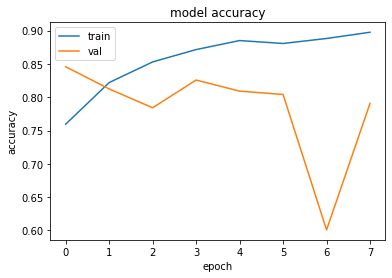

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **15. Créer le jeu de données de test**

In [22]:
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
# 	test_dataset,               # chemin vers le jeu de données
# 	seed=42,                     # Initialisation du générateur aléatoire (permutations)
# 	image_size=(input_dim,input_dim),   # Taille des images d'entrée
# 	batch_size=32,
#   shuffle=False,   # Taille du mini-batch
#   label_mode="categorical"    # Conversion au format One-Hot
# )

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        test_dataset,  # this is the target directory
        target_size=(input_dim,input_dim),  # all images will be resized to 150x150
        batch_size=batch_size,
        seed=42,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels



Found 210 images belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [24]:
model.load_weights("/content/drive/MyDrive/MyModels/groupe_15_model_DenseNet201.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/MyModels/resnet50_f_checkpoint.h5")

In [25]:
model.evaluate(test_generator)

27/27 [==============================] - 6s 227ms/step - loss: 0.6479 - accuracy: 0.7381


[0.6479491591453552, 0.738095223903656]

with last checkpoint

In [ ]:
model.evaluate(test_generator)

with best checkpoint

In [ ]:
!unzip  "/content/drive/MyDrive/dataset_fire/archive (1).zip" -d /content/drive/MyDrive/dataset_fire/dataset_aux

In [ ]:
!cp /content/drive/MyDrive/dataset_fire/dataset_aux/ForestFireDataset/Training/fire/* /content/drive/MyDrive/dataset_fire/small/fire/ 

In [ ]:
!cp /content/drive/MyDrive/dataset_fire/dataset_aux/ForestFireDataset/Training/nofire/* /content/drive/MyDrive/dataset_fire/small/no_fire/ 

In [ ]:
!cp -r bases/ drive/MyDrive/dataset_fire

In [ ]:
!cp best_checkpoint.h5 drive/MyDrive/InceptionV3_checkpoint.h5

In [ ]:
!cp final_model.h5 drive/MyDrive/Xception_checkpoint__.h5

In [ ]:
model.evaluate(test_generator)

#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

In [ ]:
train_ds.class_names

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "/content/bases/test/start_fire/test104.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()